In [1]:
import time
import numpy as np
from psygine.datasets.utils import readcfl
from psygine.decoders.utils import ifft2c

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

def show_grid_image(X):
    cols = int(np.ceil(np.sqrt(X.shape[0])))
    rows = int(np.ceil(X.shape[0] / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(len(X)):
        magnitude = np.abs(X[i])
        phase = np.angle(X[i])
        mag_norm = magnitude / (np.max(magnitude) + 1e-6)  # Avoid division by zero
        hsv = np.zeros((*mag_norm.shape, 3), dtype=np.float32)
        hsv[..., 0] = (phase + np.pi) / (2 * np.pi)
        hsv[..., 1] = 1.0
        hsv[..., 2] = mag_norm
        rgb = hsv_to_rgb(hsv)

        axes[i].imshow(rgb, aspect='auto')
        axes[i].axis('off')

    for j in range(len(X), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
!test -f knee.cfl || wget https://raw.githubusercontent.com/mikgroup/espirit-python/master/data/knee.cfl
!test -f knee.hdr || wget https://raw.githubusercontent.com/mikgroup/espirit-python/master/data/knee.hdr

In [4]:
X = readcfl("knee")
X = np.transpose(X, (3, 0, 1, 2))
X = np.ascontiguousarray(np.squeeze(X))
[N_CH, N_PE, N_SPE] = X.shape

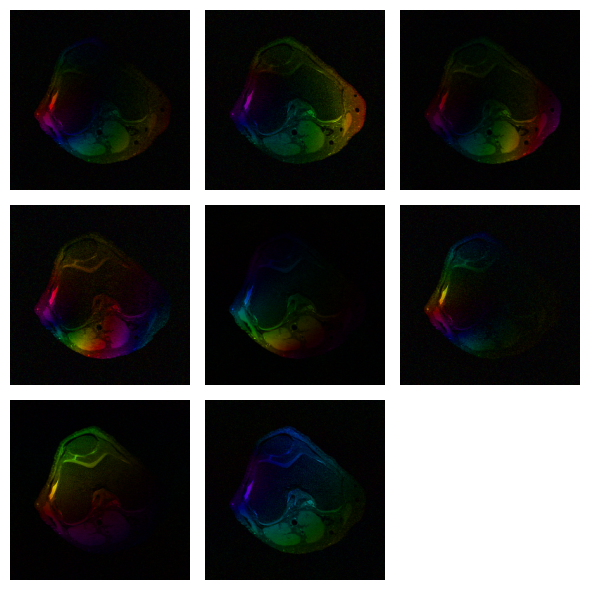

In [ ]:
show_grid_image(ifft2c(X))

## Compare different ESPIRiTs

In [6]:
from psygine.decoders.mri import espirit
from psygine.decoders.utils import fftnc, ifftnc, zcrop, fastsvd
from psygine.decoders.mri.cc import calcSCCMtx
from joblib import Parallel, delayed

The below code is adapted from the mikgroup for comparison.

In [7]:
# code adapted from https://github.com/mikgroup/espirit-python

def espirit_mikgroup(X, k, r, t, c):
    """
    ESPIRiT from mikgroup, comparison only.

    Arguments:
      X: Multi channel k-space data. Expected dimensions are (sx, sy, sz, nc), where (sx, sy, sz) are volumetric
         dimensions and (nc) is the channel dimension.
      k: Parameter that determines the k-space kernel size. If X has dimensions (1, 256, 256, 8), then the kernel
         will have dimensions (1, k, k, 8)
      r: Parameter that determines the calibration region size. If X has dimensions (1, 256, 256, 8), then the
         calibration region will have dimensions (1, r, r, 8)
      t: Parameter that determines the rank of the auto-calibration matrix (A). Singular values below t times the
         largest singular value are set to zero.
      c: Crop threshold that determines eigenvalues "=1".
    Returns:
      maps: This is the ESPIRiT operator. It will have dimensions (sx, sy, sz, nc, nc) with (sx, sy, sz, :, idx)
            being the idx'th set of ESPIRiT maps.
    """

    sx = np.shape(X)[0]
    sy = np.shape(X)[1]
    sz = np.shape(X)[2]
    nc = np.shape(X)[3]

    sxt = (sx // 2 - r // 2, sx // 2 + r // 2) if (sx > 1) else (0, 1)
    syt = (sy // 2 - r // 2, sy // 2 + r // 2) if (sy > 1) else (0, 1)
    szt = (sz // 2 - r // 2, sz // 2 + r // 2) if (sz > 1) else (0, 1)

    # Extract calibration region.
    C = X[sxt[0] : sxt[1], syt[0] : syt[1], szt[0] : szt[1], :].astype(np.complex64)

    # Construct Hankel matrix.
    p = (sx > 1) + (sy > 1) + (sz > 1)
    A = np.zeros([(r - k + 1) ** p, k**p * nc]).astype(np.complex64)

    idx = 0
    for xdx in range(max(1, C.shape[0] - k + 1)):
        for ydx in range(max(1, C.shape[1] - k + 1)):
            for zdx in range(max(1, C.shape[2] - k + 1)):
                # numpy handles when the indices are too big
                block = C[xdx : xdx + k, ydx : ydx + k, zdx : zdx + k, :].astype(
                    np.complex64
                )
                A[idx, :] = block.flatten()
                idx = idx + 1

    # Take the Singular Value Decomposition.
    U, S, VH = np.linalg.svd(A, full_matrices=True)
    V = VH.conj().T

    # Select kernels.
    n = np.sum(S >= t * S[0])
    V = V[:, 0:n]

    kxt = (sx // 2 - k // 2, sx // 2 + k // 2) if (sx > 1) else (0, 1)
    kyt = (sy // 2 - k // 2, sy // 2 + k // 2) if (sy > 1) else (0, 1)
    kzt = (sz // 2 - k // 2, sz // 2 + k // 2) if (sz > 1) else (0, 1)

    # Reshape into k-space kernel, flips it and takes the conjugate
    kernels = np.zeros(np.append(np.shape(X), n)).astype(np.complex64)
    kerdims = [
        (sx > 1) * k + (sx == 1) * 1,
        (sy > 1) * k + (sy == 1) * 1,
        (sz > 1) * k + (sz == 1) * 1,
        nc,
    ]
    for idx in range(n):
        kernels[kxt[0] : kxt[1], kyt[0] : kyt[1], kzt[0] : kzt[1], :, idx] = np.reshape(
            V[:, idx], kerdims
        )

    # Take the iucfft
    axes = (0, 1, 2)
    kerimgs = np.zeros(np.append(np.shape(X), n)).astype(np.complex64)
    for idx in range(n):
        for jdx in range(nc):
            ker = kernels[::-1, ::-1, ::-1, jdx, idx].conj()
            kerimgs[:, :, :, jdx, idx] = (
                fftnc(ker, axes) * np.sqrt(sx * sy * sz) / np.sqrt(k**p)
            )

    # Take the point-wise eigenvalue decomposition and keep eigenvalues greater than c
    maps = np.zeros(np.append(np.shape(X), nc)).astype(np.complex64)
    for idx in range(0, sx):
        for jdx in range(0, sy):
            for kdx in range(0, sz):

                Gq = kerimgs[idx, jdx, kdx, :, :]

                u, s, vh = np.linalg.svd(Gq, full_matrices=True)
                for ldx in range(0, nc):
                    if s[ldx] ** 2 > c:
                        maps[idx, jdx, kdx, :, ldx] = u[:, ldx]
    return maps

The below code is a naive implementation of ESPIRiT based on my blog. An improved version is imported from my psygine package.

In [12]:
def construct_hankel(calib_data, kernel_size):
    """Construct Block-Hankel matrix from calibration data.

    Parameters
    ----------
    calib_data : array_like
        Calibration data of shape (Nc, Nx, Ny, Nz), where Nc is the number of channels.
    kernel_size : array_like
        Size of the kernel. Should be of shape (Kx, Ky, Kz).

    Returns
    -------
    A : array_like
        Block-Hankel matrix of shape (N_kernels, np.prod(kernel_size) * Nc), where N_kernels is the number of kernels.
        Local pathches are flattened along the last axis.
    """
    Nc, Nx, Ny, Nz = calib_data.shape

    kernel_dims = np.array([Nx, Ny, Nz]) - np.array(kernel_size) + 1
    Nk = np.prod(kernel_dims)
    A = np.zeros((Nk, np.prod(kernel_size) * Nc), dtype=calib_data.dtype)

    # let numpy handle the indexing
    for i in range(Nk):
        # slide along the last axis
        local_idxs = np.unravel_index(i, kernel_dims, order="C")
        local_slices = [slice(0, Nc)]
        local_slices.extend(
            [slice(idx, idx + kernel_size[i]) for i, idx in enumerate(local_idxs)]
        )
        local_slices = tuple(local_slices)
        # flatten the local patch along the last axis
        A[i, :] = calib_data[local_slices].flatten()
    return A

def espirit_Gq(
    k_data,
    calib_size=[24, 24, 24],
    kernel_size=[6, 6, 6],
    map_dims=None,
    ns_threshold=1e-3,
    n_maps=1,
):
    """Deprecated. This version of ESPIRiT computes the Gq operator, following the same procedure as the original ESPIRiT paper."""
    Nc, Nx, Ny, Nz = k_data.shape
    calib_data = zcrop(k_data, (Nc, *calib_size))
    if map_dims is None:
        map_dims = (Nx, Ny, Nz)

    A = construct_hankel(calib_data, kernel_size)
    U, S, Vh = fastsvd(A, method="matlab")

    n_kernels = np.sum(S >= ns_threshold * S[0])
    # subspace
    Vh = Vh[:n_kernels, :]

    # Reshape into k-space kernel
    kernels = np.reshape(Vh, (n_kernels, Nc, *kernel_size))
    # The kernels are in the form of (Nk, Nc, Kx, Ky, Kz)
    # padding the kernels to match the map dimensions
    # the kerimgs are in the form of (Nk, Nc, map_dims[0], map_dims[1], map_dims[2])
    kerimgs = zcrop(kernels, (n_kernels, Nc, *map_dims))

    kerimgs = ifftnc(
        kerimgs, axes=(-3, -2, -1)
    )  # see my blog post why we use ifftnc here
    # kerimgs = fftnc(kerimgs[:, :, ::-1, ::-1, ::-1], axes=(-3, -2, -1))

    # M^{-1/2}N^{1/2}
    kerimgs *= np.sqrt(np.prod(map_dims)) / np.sqrt(np.prod(kernel_size))

    def _espirit_maps(
        i, j, k, n_components=1):
        Gq = kerimgs[..., i, j, k]

        U, s, vh = fastsvd(Gq.T, k=n_components, method="matlab")

        return U

    # Take the point-wise eigenvalue decomposition and keep eigenvalues greater than c
    maps = np.stack(
        Parallel(n_jobs=-1)(
            delayed(_espirit_maps)(
                i,
                j,
                k,
                n_components=n_maps,
            )
            for i in range(map_dims[0])
            for j in range(map_dims[1])
            for k in range(map_dims[2])
        ),
        axis=0,
    )

    maps = np.reshape(maps, (*map_dims, Nc, n_maps))
    maps = np.transpose(maps, (4, 3, 0, 1, 2))
    
    return maps

In [9]:
%load_ext memory_profiler

In [10]:
%%memit

start_time = time.perf_counter()
maps = espirit(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH, 
    crop_threshold=0,
    rotphase=False,
    normalize=False)
end_time = time.perf_counter()
maps = np.squeeze(maps[0])
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 3.138567 seconds
peak memory: 534.78 MiB, increment: 253.09 MiB


In [13]:
%%memit

start_time = time.perf_counter()
maps_Gq = espirit_Gq(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH)
maps_Gq = np.squeeze(maps_Gq[0])
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

/home/swolf/miniconda3/envs/science/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:113: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
  warnings.warn(
Traceback (most recent call last):
  File "/home/swolf/miniconda3/envs/science/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 274, in main
    del registry[rtype][name]
KeyError: '/loky-358726-sg9e_dx2'
Traceback (most recent call last):
  File "/home/swolf/miniconda3/envs/science/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 274, in main
    del registry[rtype][name]
KeyError: '/loky-358726-fstrkx6p'
Traceback (most recent call last):
  File "/home/swolf/miniconda3/envs/science/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 274, in main
    del registry[rtype][name]
KeyError: '/loky-358726-92o8y2lo'
Traceback (most recent call l

Time elapsed: 6.017926 seconds
peak memory: 1633.93 MiB, increment: 1187.10 MiB


In [14]:
%%memit

start_time = time.perf_counter()
maps_mik = espirit_mikgroup(
    np.transpose(X.reshape(-1, 1, *X.shape[-2:]), (1, 2, 3, 0)),
    k=6,
    r=24,
    t=1e-2,
    c=0)
maps_mik = np.transpose(maps_mik, (4, 3, 0, 1, 2))
maps_mik = np.squeeze(maps_mik[0])
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 111.763002 seconds
peak memory: 1409.94 MiB, increment: 839.51 MiB


My improved version is much memory efficient than the naive one, reducing memory consumption by a factor of 3 in this 2D case.

There is also a phase ambiguity problem, which is quite obvious in parallel computing scheme.

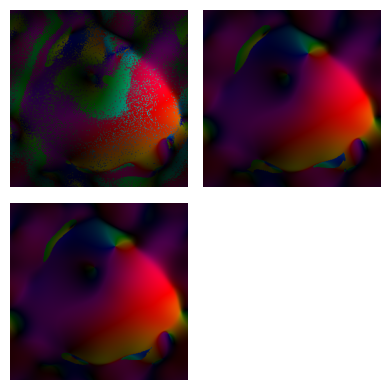

In [23]:
idx = 1
show_grid_image(np.stack([maps[idx], maps_Gq[idx], maps_mik[idx]]))

## Resolve phase ambiguity by coil, pca and vcc-espirit

In [18]:
%%memit

start_time = time.perf_counter()
maps_first = espirit(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH, 
    crop_threshold=0,
    rotphase=True,
    rotmethod='first')
end_time = time.perf_counter()
maps_first = np.squeeze(maps_first[0])
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 3.287373 seconds
peak memory: 712.51 MiB, increment: 94.10 MiB


In [19]:
%%memit

start_time = time.perf_counter()
maps_pca = espirit(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH, 
    crop_threshold=0,
    rotphase=True,
    rotmethod='pca')
end_time = time.perf_counter()
maps_pca = np.squeeze(maps_pca[0])
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 2.861171 seconds
peak memory: 775.68 MiB, increment: 114.48 MiB


In [20]:
%%memit

start_time = time.perf_counter()
maps_vcc = espirit(
    X.reshape(-1, 1, *X.shape[-2:]), 
    calib_size=[1, 24, 24], 
    kernel_size=[1, 6, 6], 
    map_dims=[1, N_PE, N_SPE], 
    ns_threshold=1e-2, 
    n_maps=N_CH, 
    crop_threshold=0,
    rotphase=True,
    rotmethod='vcc')
end_time = time.perf_counter()
maps_vcc = np.squeeze(maps_vcc[0])
print(f"Time elapsed: {end_time - start_time:.6f} seconds")

Time elapsed: 4.002581 seconds
peak memory: 1185.18 MiB, increment: 480.02 MiB


In theory, vcc-espirit retrieves the actual phase of coil sensitivities, proved by the similar phase pattern in the first and last images. 

As you can see, the sign alignment procedure is not perfect.

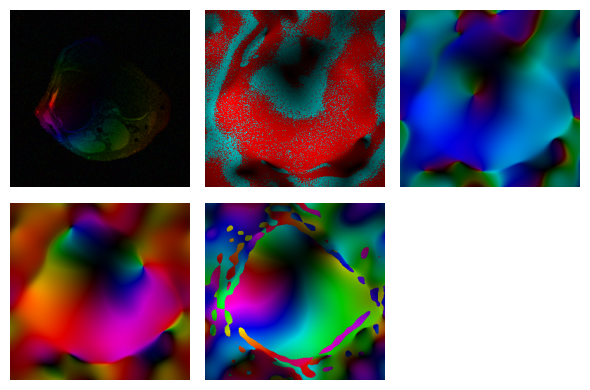

In [27]:
idx = 0
show_grid_image(
    np.stack([ifft2c(X)[idx],maps[idx], maps_first[idx], maps_pca[idx], maps_vcc[idx]]))